# 01 Umbildungen

Mit einer affinen Transformation in der Ebene der Form
$$
\begin{pmatrix}x' \cr y' \end{pmatrix} = \begin{pmatrix} a_{11} a_{12} \cr a_{21}\ a_{22} \end{pmatrix} \begin{pmatrix}x \cr y\end{pmatrix} + \begin{pmatrix}a-{10} \cr a_{20} \end{pmatrix}
$$

bzw.

$$
\vec{x}' = A \vec{x} + \vec{a}_0
$$

lassen sich viele in der Praxis wichtigen Bildtransformationen beschreiben (z.B. Drehungen,
oder Skalierungen).

![](./images/transformation.png)

Die häufigste Methode zur Durchführung solcher Bildtransformationen ist die *indirekte
Umbildung* (s.Diagramm). Sie beginnt mit einer zunächst leeren Bildmatrix(oft größer gewählt
als das Ausgangsbild). Anschließend werden die Koordinaten der Pixelmittelpunkte mit der
inversen Transformation auf ihre ursprüngliche Position im Ausgangsbild zurückgerechnet
und der dortige Grauwert ausgelesen.

Bitte beachten Sie, dass die y-Achse im Bild entgegen der sonst üblichen Konvention nach
unten statt nach oben zeigt, d.h. bei der in der Mathematik übliche Konvention handelt
es sich um ein *rechtshändiges* Koordinatensystem, während in Bildern ein *linkshändiges*
Koordinatensystem verwendet wird. Damit Operationen wie Drehungen oder Verschiebungen das erwartete Ergebnis zeigen, ist es sinnvoll, die Transformation zwischen links- und rechtshändigem Koordinatensystem explizit zu implementieren. Bei der indirekten Umbildung
heißt das, dass wir die Gesamttransformation in drei explizite Schritte unterteilen, die hinter-
einander ausgeführt werden:
1. Transformation linkshändiges KS (Zielbild) in rechtshändiges
KS;
2. inverse affine Transformation;
3. Transformation rechtshändiges KS in linkshändiges KS (Ausgangsbild). Die Gesamttransformation ergibt sich dann mathematisch durch die Multiplikation der entsprechenden Matritzen.

Da die Ausgangspositionen fast nie auf einem Pixelmittelpunkt liegen, muß entweder der
Grauwert des nächstliegenden Pixelmittelpunktes genommen (im unten gezeigten Beispiel
wäre das P1) oder bilinear interpoliert werden.

![](./images/interpolation.png)

Für die bilineare Interpolation wird ein gewichteter Mittelwert aus den Grauwerten der 4
Nachbarpunkte berechnet (s. Zeichnung): jeder Nachbarpunkt wird dabei mit dem diagonal
gegenüberliegenden Flächenanteil gewichtet, d.h. $P1$ mit $A4$, $P2$ mit $A3$, $P3$ mit $A2$ und $P4$
mit $A1$. Der interpolierte Grauwert an der Stelle $X$ ist dann
$$
g_X = A_{4g}(P_1) + A_{3g}(P_2) + A_{2g}(P_3) + A_{1g}(P_4)
$$
Damit erhalten die Nachbarpunkte ein um so höheres Gewicht, je näher sie an X liegen.


# Aufgaben:

In [2]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

In [3]:
def display_images(images, descriptions=None, title=None):
    n = len(images)

    if descriptions is None:
        descriptions = ['Original', 'Transformed']

    descriptions = descriptions[:n] + [''] * max(0, n - len(descriptions))

    fig = plt.figure()

    if title:
        fig.suptitle(title)

    for i, img in enumerate(images, 1):
        ax = fig.add_subplot(1, n, i)
        ax.imshow(img)
        ax.axis('off')
        if descriptions[i - 1]:
            ax.set_title(descriptions[i - 1])

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [4]:
def get_transformation_matrix(rotate=0, x_scale=1, y_scale=1, diag_scale=1, perp_scale=1):
    rad = np.deg2rad(rotate)
    matrix_a = np.array([
        [x_scale * np.cos(rad), -y_scale * np.sin(rad)],
        [x_scale * np.sin(rad),  y_scale * np.cos(rad)]
    ])

    if diag_scale != 1 or perp_scale != 1:

        rotation_matrix_45 = (
            np.array([
                [np.cos(np.pi/4), -np.sin(np.pi/4)],
                [np.sin(np.pi/4),  np.cos(np.pi/4)]
            ]))

        matrix_a = (rotation_matrix_45
                    .dot(np.diag([diag_scale, perp_scale]))
                    .dot(rotation_matrix_45.T)
                    .dot(matrix_a))

    return matrix_a

def center_in_frame(img, matrix_a):
    img_height, img_width = np.shape(img)[:2]
    center = np.array([img_width/2, img_height/2])

    return np.array([img_width/2, img_height/2]) - matrix_a.dot(center)

### Teil A
Schreiben Sie eine Python-Funktion, mit der sich ein Bild affin transformieren lässt.
Übergabeparameter sind die Matrix A, der Verschiebungsvektor $\vec{a_0}$ und das Eingangsbild,
zurückgegeben wird das affin verzerrte Ausgangsbild. Sehen Sie dabei vor, dass der Benutzer
zwischen Nächster-Nachbar- und bilinearer Interpolation wählen kann, aber implementieren
Sie zunächst nur die einfachere Nächster-Nachbar-Interpolation. Alle Pixel, deren Ausgangs-
position außerhalb des Eingangsbildes liegen, werden auf 0 gesetzt. Die Funktion soll sowohl
Grauwert- als auch Farbbilder verarbeiten können.

In [5]:
def nearest_neighbor(img, loc):
    x_loc, y_loc = int(round(loc[0])), int(round(loc[1]))

    try:
        if x_loc > -1 and y_loc > -1:
            return img[y_loc][x_loc]
    except IndexError:
        pass

    return [0, 0, 0]

def affine_transform(matrix_a, a_0, image, interpolation_function):

    target_matrix = np.zeros_like(image)

    if np.linalg.det(matrix_a) == 0:
        print("Transformation not possible: det(A^-1) = 0")
        return target_matrix

    img_height, img_width = np.shape(target_matrix)[:2]
    inverse_a = np.linalg.inv(matrix_a)

    for y in range(img_height):
        for x in range(img_width):

            x_src = inverse_a.dot([x, y] - a_0)
            target_matrix[y][x] = interpolation_function(img, x_src)

    return target_matrix

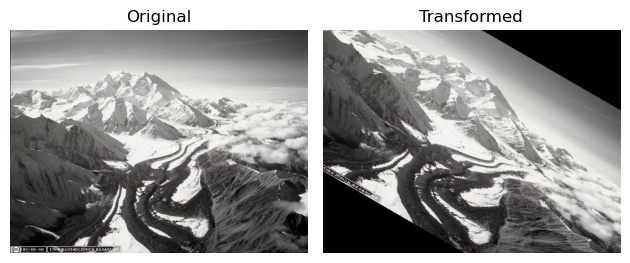

In [6]:
img = imread('./data/gletscher.jpg')

matrix_a = get_transformation_matrix(30, 1.3, 0.9)
a_0 = center_in_frame(img, matrix_a)

transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)

display_images([img,transformed_img])

### Teil B
Wie sieht die affine Transformation von einem linkshändigen Koordinatensystem in ein
rechtshändiges Koordinatensystem aus? Wie deren Umkehrung? Implementieren Sie eine
Gesamttransformation zur affinen Umbildung, bestehend aus der Folge
1. Transformation links- in rechtshändiges KS;
2. Inverse affine Transformation;
3. Transformation rechts- in linkshändiges KS. Testen Sie Ihre Funktion, indem Sie ein beliebiges Bild (z.B. gletscher.jpg)
um 20 Pixel diagonal nach rechts unten verschieben, wobei der zugehörige Translationsvektor
in rechtshändigen Koordinaten gegeben ist.

In [7]:
def flip_y_axis(img):
    # img_height, img_width = np.shape(img)[:2]
    #
    # C = np.array(
    #     [
    #         [1, 0],
    #         [0, -1]
    #     ]
    # )
    # t = np.array([0, img_height - 1])
    #
    # out = np.zeros_like(img)
    #
    # for y in range(img_height):
    #     for x in range(img_width):
    #         coord = C.dot(np.array([x, y])) + t   # → [col, row]
    #         col, row = coord                      # x_src, y_src
    #         out[y, x] = img[row, col]
    #
    # return out

    return img[::-1]

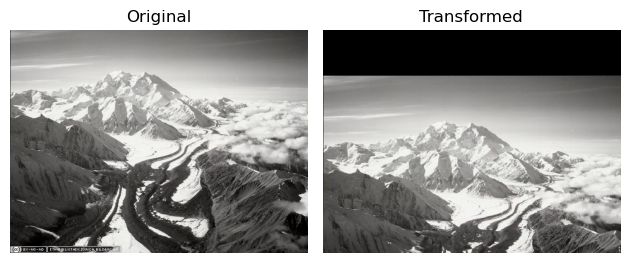

In [8]:
img = imread('./data/gletscher.jpg')

matrix_a = get_transformation_matrix(0, 1.1, 1.1)
a_0 = np.array([0, 100])

transformed_img = affine_transform(matrix_a, a_0, flip_y_axis(img), nearest_neighbor)

display_images([img, transformed_img])

### Teil C
Ergänzen Sie nun Ihre Funktion um die bilineare Interpolation. Testen Sie Ihre Interpolation,
indem Sie ein kleines Testbild (ca. 30 × 30 Pixel groß) um den Faktor 10.5 vergrößern. Wie
sehen die vergrößerten Pixel bei den beiden Interpolationsmethoden aus?

In [9]:
def bilinear_neighbor(img, loc):
    if np.array_equal(loc, np.floor(loc)):
        return img[int(loc[1])][int(loc[0])]

    x0, y0 = int(np.floor(loc[0])), int(np.floor(loc[1]))
    adjacent_pixels = img[y0:y0+2, x0:x0+2]

    dx, dy = loc[0] - x0, loc[1] - y0

    return (adjacent_pixels[0,0] * (1 - dx) * (1 - dy)
            + adjacent_pixels[0,1] * dx       * (1 - dy)
            + adjacent_pixels[1,0] * (1 - dx) * dy
            + adjacent_pixels[1,1] * dx       * dy)

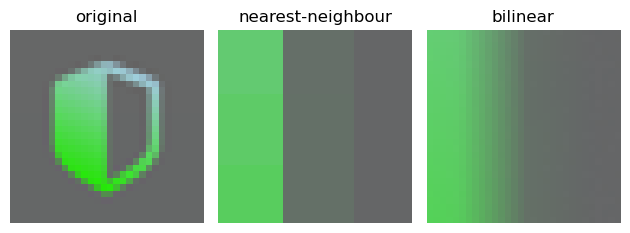

In [10]:
img = imread('./data/30x30.png')

matrix_a = get_transformation_matrix(0, 10.5, 10.5)
a_0 = center_in_frame(img, matrix_a)

nn_transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)
bl_transformed_img = affine_transform(matrix_a, a_0, img, bilinear_neighbor)

display_images([img, nn_transformed_img, bl_transformed_img],  ['original', 'nearest-neighbour', 'bilinear'])

### Teil D
Führen Sie folgende affine Transformationen durch geeignete Wahl der Matrix `A` aus:
1. Drehen Sie ein beliebiges Bild (z.B. gletscher.jpg) um 30◦;
2. verkleinern Sie es in x-Richtung um den Faktor 0.8, vergrößern Sie es in y-Richtung um den Faktor 1.2;
3. Dehnen Sie das Bild entlang der Diagonalen um 1.5, stauchen Sie senkrecht dazu um 0.5;
4. Entzerren Sie das Objekt zu Füßen der Botschafter im Bild ambassadors.jpg. Vergleichen Sie dabei die
Ergebnisse für Nächste-Nachbar- und bilineare Interpolation. Hierbei ist es hilfreich, iterativ
vorzugehen, d.h. zuerst das Bild grob zu entzerren und dann schrittweise zu verfeinern,
jeweils durch trial and error.

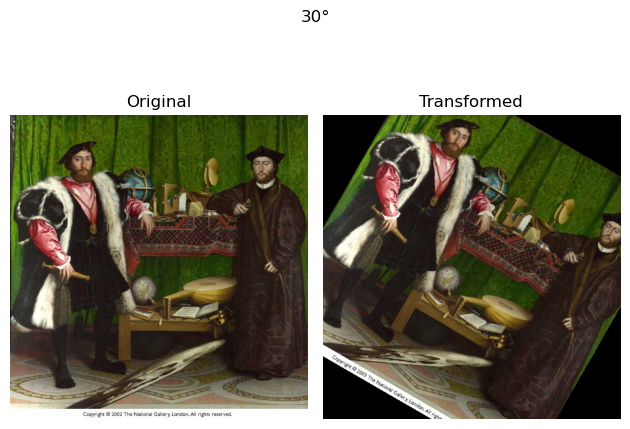

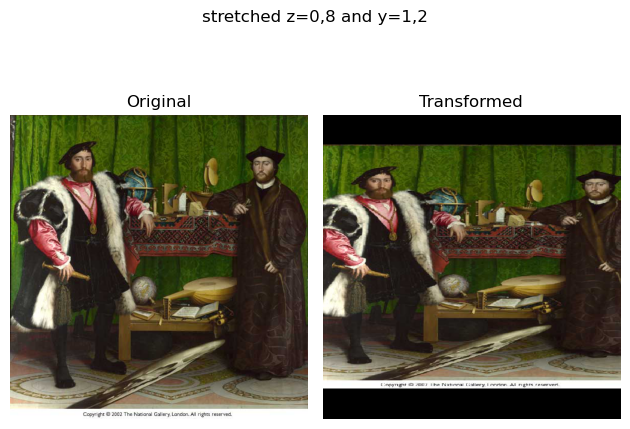

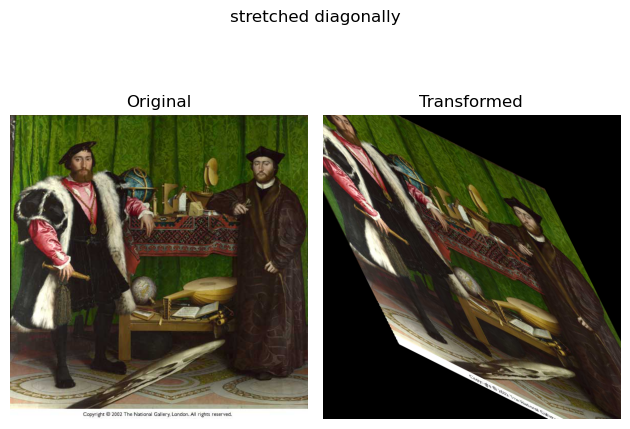

In [12]:
img = imread('./data/ambassadors.jpg')

# 30 Grad
matrix_a = get_transformation_matrix(30)
a_0 = center_in_frame(img, matrix_a)
transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)
display_images([img, transformed_img], title="30°")

# stretched
matrix_a = get_transformation_matrix(0, 1.2, 0.8)
a_0 = center_in_frame(img, matrix_a)
transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)
display_images([img, transformed_img], title="stretched z=0,8 and y=1,2")

# diagonal
matrix_a = get_transformation_matrix(diag_scale=1.5, perp_scale=0.5)
a_0 = center_in_frame(img, matrix_a)
transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)
display_images([img, transformed_img], title="stretched diagonally")

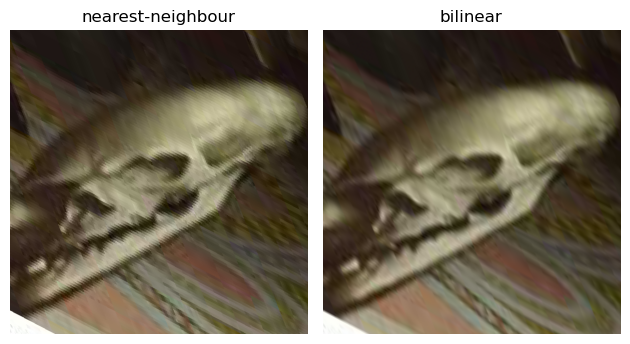

In [107]:
# stretched
# matrix_a = get_diagonal_stretch_matrix(4.1,1.9)
matrix_a = get_transformation_matrix(5, y_scale=2, diag_scale=5.1, perp_scale=1.9)
a_0 = center_in_frame(img, matrix_a)
a_0 += [-560, -1380]

nn_transformed_img = affine_transform(matrix_a, a_0, img, nearest_neighbor)
bl_transformed_img = affine_transform(matrix_a, a_0, img, bilinear_neighbor)

display_images([nn_transformed_img, bl_transformed_img], ['nearest-neighbour', 'bilinear'])

### Nützliche Python-Funktionen:
1. zur Darstellung von Bildern können Sie die Funktion `imshow()` aus dem Python-Paket matplotlib verwenden;
2. Bilder können am bequemsten mit `skimage.data.imread()` aus dem Paket scikit-image eingelesen werden;
3. Wenn Bilder in Python eingelesen werden, haben sie meist den Datentyp uint8, für den nur eine
begrenzte Funktionalität zur Verfügung steht. Wandeln Sie daher die Bilder nach dem
Einlesen zuerst mit der Funktion `numpy.astype()` in ein Fließkommaformat um und skalieren Sie das Bild zwischen 0 und 1;
4. Die Inverse einer Matrix wird mit der Funktion `numpy.linalg.inv()` berechnet.